# Florence-2
microsoft/Florence-2-large

In [2]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import torch
import warnings
import supervision as sv

warnings.filterwarnings("ignore")

device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float32  # float16 가능하면 float16 권장
print("------------------ 0. Setup Check ------------------")
print("Using device:", device)
print("Using torch_dtype:", torch_dtype)

print("---------------------- 1. 모델 로드 ----------------------")
model_id = "microsoft/Florence-2-large"

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    torch_dtype=torch_dtype
).eval().to(device)

processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

/home/dibaeck/miniconda3/envs/proj_311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


------------------ 0. Setup Check ------------------
Using device: cuda:0
Using torch_dtype: torch.float32
---------------------- 1. 모델 로드 ----------------------


In [3]:
def run_florence(image_path, task_prompt="<OCR_WITH_REGION>", text_input=None):
    """
    Florence-2 OCR 실행 후 Supervision Detections 객체 반환
    task_prompt 중 "<OCR_WITH_REGION>"로 테스크 설정 : https://huggingface.co/microsoft/Florence-2-large
    """
    image = Image.open(image_path).convert("RGB")

    prompt = task_prompt if text_input is None else task_prompt + text_input

    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device, torch_dtype)

    generated_ids = model.generate(
            input_ids=inputs["input_ids"].cuda(),
            pixel_values=inputs["pixel_values"].cuda(),
            max_new_tokens=4096,
            num_beams=3,
            do_sample=False,
            early_stopping=True
        )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

    parsed_answer = processor.post_process_generation(
            generated_text,
            task=task_prompt,
            image_size=(image.width, image.height)
        )
    # Supervision Detections 변환
    detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, parsed_answer, resolution_wh=image.size)
    
    return image, detections, parsed_answer

def visualize_detections(image, detections):
    """
    시각화 함수
    """
    bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
    label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)
    
    annotated_image = bounding_box_annotator.annotate(scene=image.copy(), detections=detections)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)
    
    for idx,text in enumerate(detections.data['class_name']) :
        print(f'{idx+1} : {text}')
    
    return annotated_image

# TEST
한글 인식 확인을 위해 test01의 한 부분을 잘라서 테스트함.

This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (4096). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.



===== ./data/test05.PNG =====
{'<OCR_WITH_REGION>': {'quad_boxes': [[439.0570068359375, 115.24449920654297, 735.0230102539062, 115.24449920654297, 735.0230102539062, 141.239501953125, 439.0570068359375, 141.239501953125], [779.051025390625, 115.24449920654297, 908.6890258789062, 115.24449920654297, 908.6890258789062, 141.239501953125, 779.051025390625, 141.239501953125], [201.79501342773438, 47.657501220703125, 209.1330108642578, 47.657501220703125, 209.1330108642578, 61.52149963378906, 201.79501342773438, 61.52149963378906], [487.9770202636719, 45.92449951171875, 502.65301513671875, 45.92449951171875, 502.65301513671875, 61.52149963378906, 487.9770202636719, 61.52149963378906], [779.051025390625, 45.92449951171875, 791.281005859375, 45.92449951171875, 791.281005859375, 61.52149963378906, 779.051025390625, 61.52149963378906], [1072.571044921875, 47.657501220703125, 1084.801025390625, 47.657501220703125, 1084.801025390625, 61.52149963378906, 1072.571044921875, 61.52149963378906], [1363

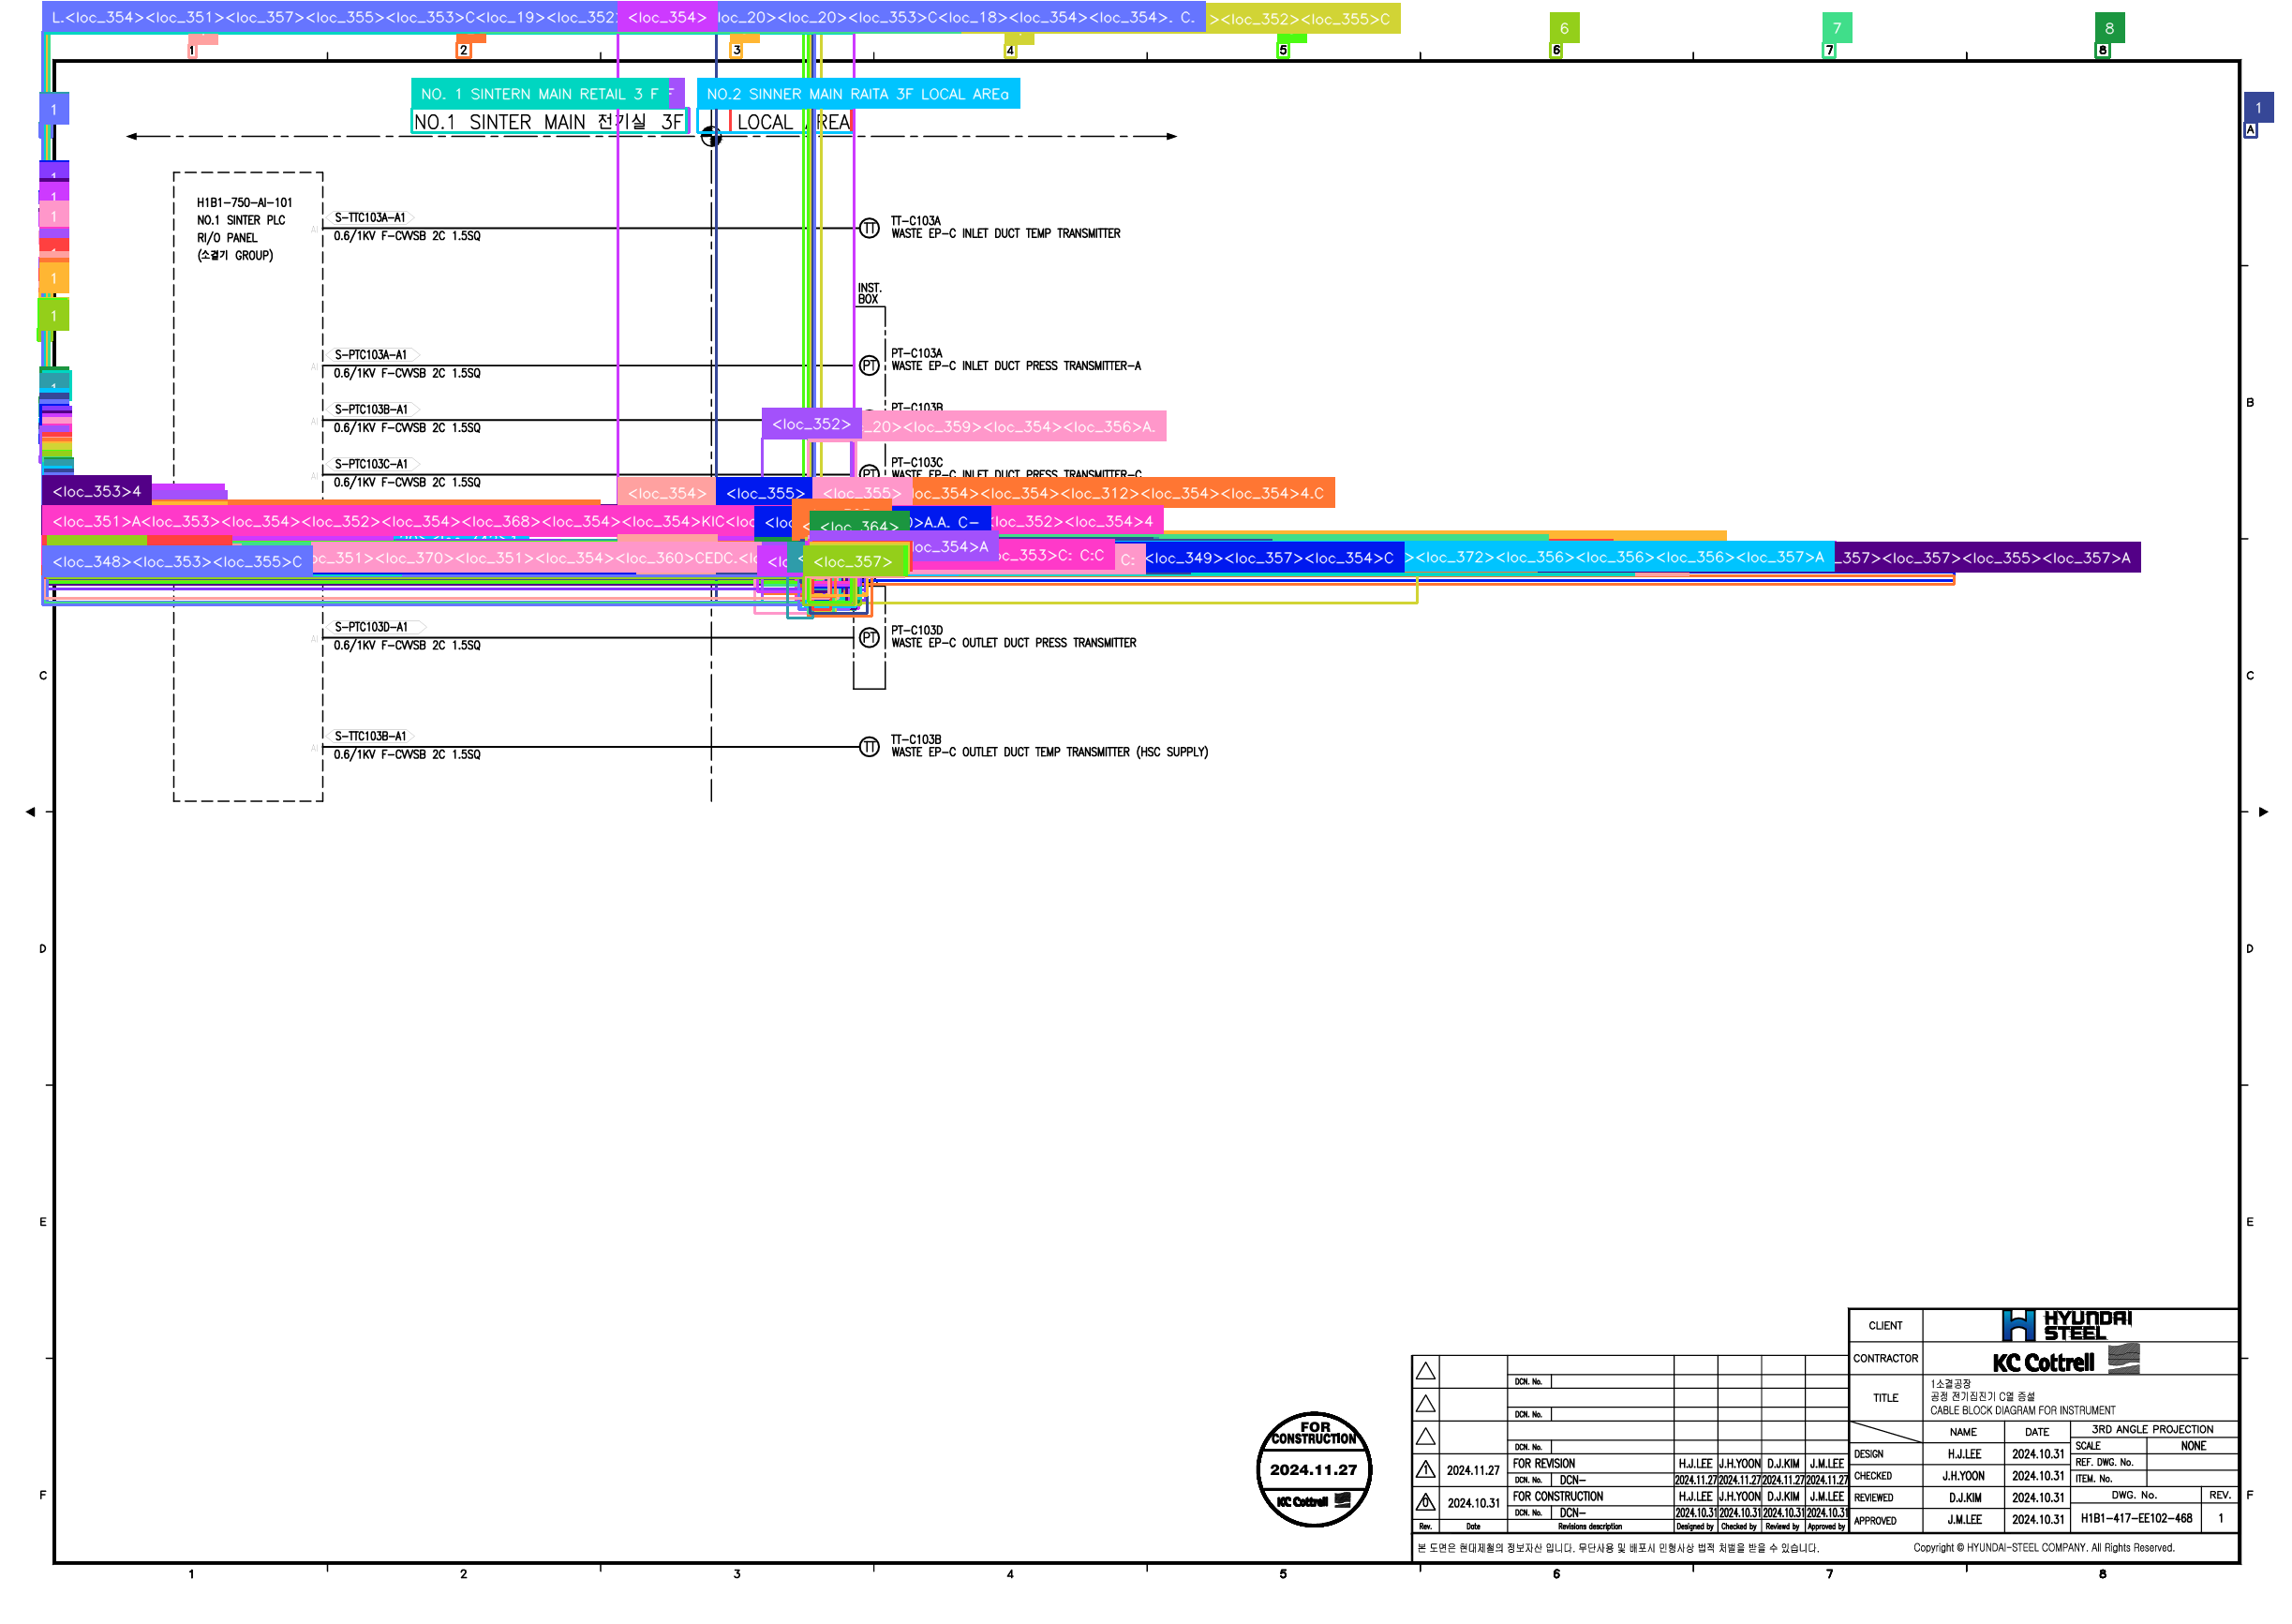

: 

In [ ]:
test_images = [
    "./data/test05.PNG",
    # "./data/test05.JPG",
]

for img_path in test_images:
    image, detections, parsed_answer = run_florence(img_path)
    print(f"\n===== {img_path} =====")
    print(parsed_answer)
    
    annotated_img = visualize_detections(image, detections)
    annotated_img.show()  # 또는 .save("output.jpg") 로 저장 가능